# Constraint tutorial

In [1]:
import utils
from utils import IpLoc, TestCircuit
import time
import numpy as np
from pathlib import Path
%matplotlib inline

The util functions work with numpy arrays. We have our own data types for taking care of constraints (IpLoc data type) as well as various IPs within the circuit (TestCircuit data type).

In [2]:
# Create the initial IpLoc data
chip_resources_path = Path('ZYNQ7000.json')
location_data = IpLoc(chip_resources_path)

In [3]:
# Create the initial IpLoc data
test_circuit_path = Path('IP_configure.yaml')
test_circuit = TestCircuit(test_circuit_path)

There are a total of 6 IPs in this design.


# RO constraints:

In [4]:
blocked_resources = location_data.copy()
for item in test_circuit.circuit.keys():
    test_circuit.locations[item] = blocked_resources.copy()
    if test_circuit.circuit[item]['IP'] == 'RO':
        Num_Oscillators = test_circuit.circuit[item]['IP_specs']['Num_Oscillators']
        Num_Stages = test_circuit.circuit[item]['IP_specs']['Num_Stages']
        max_x = test_circuit.locations[item].max_x
        max_y = test_circuit.locations[item].max_y
        for i in range(Num_Oscillators):
            x = np.random.randint(max_x)
            y = np.random.randint(max_y)
            while test_circuit.locations[item].remaining_resources[x, y] != 0:
                x = np.random.randint(max_x)
                y = np.random.randint(max_y)
            test_circuit.locations[item].remaining_resources[x, y] = 4
            for j in [test_circuit.locations[item]._lut_a, test_circuit.locations[item]._lut_b, test_circuit.locations[item]._lut_c, test_circuit.locations[item]._lut_d]:
                j[x, y] = i
        test_circuit.locations[item] = utils.check_and_propose(test_circuit.locations[item], 'L')
        blocked_resources = utils.IpLoc.block_resource(blocked_resources, test_circuit.locations[item])

100%|██████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 3765.65it/s]


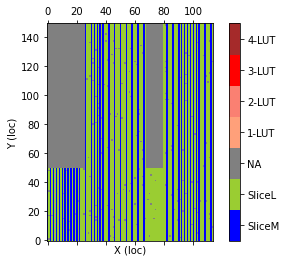

In [5]:
blocked_resources.plot_layout()

In [6]:
utils.RO_xdc(test_circuit, slice_type='L', outputfile='heater.XDC', json_output='RO_locations.json')

100%|██████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 5847.36it/s]


# BTI constraints

For BTI constraints, we want to block the resources that were previously used for RO.

In [ ]:
test_circuit.locations['BTI0'] = blocked_resources.copy()
for item in test_circuit.circuit.keys():
    if test_circuit.circuit[item]['IP'] == 'BTI':
        Num_Oscillators = test_circuit.circuit[item]['IP_specs']['Num_Oscillators']
        max_x = test_circuit.locations[item].max_x
        max_y = test_circuit.locations[item].max_y
        for i in range(Num_Oscillators):
            x = np.random.randint(max_x)
            y = np.random.randint(max_y)
            while test_circuit.locations[item].remaining_resources[x, y] != 0:
                x = np.random.randint(max_x)
                y = np.random.randint(max_y)
            test_circuit.locations[item].remaining_resources[x, y] = 3
            for j in [test_circuit.locations[item]._lut_a, test_circuit.locations[item]._lut_b, test_circuit.locations[item]._lut_c]:
                j[x, y] = i
        test_circuit.locations[item] = utils.check_and_propose(test_circuit.locations[item], 'L')
        blocked_resources = utils.IpLoc.block_resource(blocked_resources, test_circuit.locations[item])

In [ ]:
blocked_resources.plot_layout()

In [ ]:
utils.BTI_xdc(test_circuit, slice_type='L', outputfile='BTIs.XDC',json_output='BTI_locations.json')

# Heater constraints:

For the heater we want to block off the areas that other sensors are located and place the heater on the remaining resources.

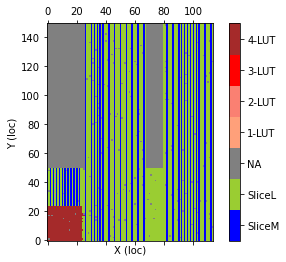

In [7]:
for item in test_circuit.circuit.keys():
    if test_circuit.circuit[item]['IP'] == 'heater':
        test_circuit.locations[item] = blocked_resources
blocked_resources = utils.heater_xdc(test_circuit, init_coord=(0, 0), dim=(24, 24), outputfile='heater.XDC')
blocked_resources.plot_layout()